# Result Validation

In [6]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
import torch
import torchvision.transforms as transforms
import pandas as pd

In [8]:
DATASET_PATH = '/data/histopathologic-cancer-detection/'

In [9]:
model_type = '3conv3fc'

dataset = 'cancer'

In [10]:
import json
def load_configuration(filename, path='./configuration'):
    with open(f'{path}/{filename}') as f:
        configuration = json.load(f)
    return configuration

In [12]:
config = load_configuration(filename=f'frequentist-{model_type}-{dataset}.json', path='./../bayes_by_backprop/configuration')
batch_size = 60
img_size = config['img_size']
n_channels = config['n_channels']
weight_decay = config['weight_decay']

In [13]:
# define data transformations
common_trans = [
    transforms.CenterCrop((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.6976, 0.5404, 0.6897],
                         std=[0.2433, 0.2839, 0.2199])
]

transform_test = transforms.Compose(common_trans)

use_cuda = torch.cuda.is_available()
torch.cuda.set_device(0)

## Functions to run Testing

In [14]:
from torchvision.models import ResNet
from torchvision.models.resnet import BasicBlock
import torch.utils.model_zoo as model_zoo
import math
import torch
from torch.distributions import Categorical

In [15]:
import os
from glob import glob
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
from torchvision.transforms import transforms
from PIL import Image


class HistoPathologicCancer(Dataset):
    """Histo-Pathologic Cancer Dataset with binary labeling: Finding/No-Finding"""

    def __init__(self, path=None, img_size=64, dataset_type='train', transform=None, n_channels=3, is_debug=False):
        self.path = path if path is not None \
            else '/home/alberto/Desktop/datasets/histopathologic-cancer-detection/'
        self.img_size = img_size
        self.dataset_type = dataset_type
        if self.dataset_type not in ['train', 'validation', 'test']:
            raise RuntimeError



        self.n_channels = n_channels
        self.is_debug = is_debug

        # define transformation
        self.transform = transform
        if self.transform is None:
            self.transform = transforms.Compose([
                                transforms.Resize((img_size, img_size)),
                                transforms.ToTensor()])

        self.transform_target = transforms.ToTensor()

        self.df_data = pd.read_csv(os.path.join(self.path, 'train_labels.csv'))

        if is_debug:
            self.df_data = self.df_data[:512]

        # create training/validation set
        train, validation_and_test = train_test_split(self.df_data, random_state=42, shuffle=True, test_size=0.4)
        validation, test = train_test_split(validation_and_test, random_state=42, shuffle=True, test_size=0.5)

        if self.dataset_type == 'train':
            self.df_data = train
        elif self.dataset_type == 'validation':
            self.df_data = validation
        elif self.dataset_type == 'test':
            self.df_data = test
        else:
            raise ValueError

    def __len__(self):
        return len(self.df_data)

    def __getitem__(self, idx):
        item = self.df_data.iloc[idx]
        img = self.get_rgb_image_from_file(os.path.join(self.path, 'train', ''.join([item['id'],
                                                                                     '.tif'])))
        img = self.transform(img)
        label = np.array(item['label'])
        label = torch.from_numpy(label)
        return img, label

    def load_image_from_file(self, filename):
        return Image.open(filename)

    def get_rgb_image_from_file(self, filename):
        return self.load_image_from_file(filename).convert('RGB')

    def get_grayscale_image_from_file(self, filename):
        return self.load_image_from_file(filename).convert('L')


In [16]:
import math
import torch
from torch import nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.nn.modules.utils import _pair

cuda = torch.cuda.is_available()


class FlattenLayer(nn.Module):

    def __init__(self, num_features):
        super(FlattenLayer, self).__init__()
        self.num_features = num_features

    def forward(self, x):
        return x.view(-1, self.num_features)

In [17]:
import torch.nn as nn

class F3Conv3FC(nn.Module):
    """
    To train on CIFAR-10:
    https://arxiv.org/pdf/1207.0580.pdf
    """
    def __init__(self, outputs, inputs):
        super(F3Conv3FC, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(inputs, 32, 5, stride=1, padding=2),
            nn.Softplus(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(32, 64, 5, stride=1, padding=2),
            nn.Softplus(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 128, 5, stride=1, padding=1),
            nn.Softplus(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            FlattenLayer(2 * 2 * 128),
            nn.Linear(2 * 2 * 128, 1000),
            nn.Softplus(),
            nn.Linear(1000, 1000),
            nn.Softplus(),
            nn.Linear(1000, outputs)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        # print('X', x)
        return x


In [18]:
test_set = HistoPathologicCancer(path=DATASET_PATH, img_size=img_size, dataset_type='test',
                                transform=transform_test,
                                is_debug=False)
num_classes = 2

In [19]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)

In [21]:
model = F3Conv3FC(num_classes, n_channels).cuda()

In [22]:
from torch.nn import CrossEntropyLoss
criteria = CrossEntropyLoss()

In [24]:
# load model
model_filename = f'./../bayes_by_backprop/frequentist-{model_type}-{dataset}.dat'
print(f'Loading model from {model_filename}')
trained_model = torch.load(model_filename)
model.load_state_dict(trained_model['model'])

Loading model from ./../bayes_by_backprop/frequentist-3conv3fc-cancer.dat


In [25]:
# set to eval mode
_ = model.eval()

## Test

In [28]:
correct = 0
y_true = []
y_pred = []

fc_layer_result = []
softmax_layer_result = []
for data, target in test_loader:
#     data, target = data.cuda(), target.cuda()
    
    data = data.cuda()
    target = target.cuda()
    with torch.no_grad():
        fc = model(data)
#         plot_samples_batch(batch_samples=samples)
        fc_layer_result.append(fc.cpu().numpy())
        
        softmax = F.softmax(fc, dim=1)
        softmax_layer_result.append(softmax.cpu().numpy())
        
        _, pred = torch.max(softmax, 1)
#         pred = output.probs.argmax(1).cpu()
        
        y_pred.extend(list(pred.cpu().numpy()))
        y_true += list(target.view_as(pred).cpu().numpy())
        correct += float(pred.eq(target.view_as(pred)).cpu().sum())

accuracy = 100. * correct / float(len(test_loader.dataset))
print(f'Test set: Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy}%)')

Test set: Accuracy: 35255.0/44005 (80.11589592091808%)


In [30]:
y_all = pd.DataFrame({'y_true': y_true,
                     'y_pred': y_pred})
y_all['residuals'] = y_all['y_true'] - y_all['y_pred']
y_all.to_hdf('./test-results/y_all-Freq_3Conv3FC.h5', 'y_all')
y_all.head()

,y_true,y_pred,residuals
0,0,1,-1
1,0,0,0
2,0,0,0
3,1,1,0
4,0,0,0


In [35]:
fc_layer = np.concatenate(fc_layer_result, axis=0)
np.save(f'./network-output/fc_layer-Freq_3Conv3FC.npy', fc_layer)
fc_layer.shape

(44005, 2)

In [37]:
softmax_layer = np.concatenate(softmax_layer_result, axis=0)
np.save(f'./network-output/softmax_layer-Freq_3Conv3FC.npy', softmax_layer)
softmax_layer.shape

(44005, 2)

In [ ]:
np.save('fnumpy.npy', array_lst)

In [29]:
softmax

tensor([[0.0336, 0.9664],
        [0.9210, 0.0790],
        [0.1928, 0.8072],
        [0.1425, 0.8575],
        [0.3937, 0.6063],
        [0.8107, 0.1893],
        [0.9041, 0.0959],
        [0.9161, 0.0839],
        [0.9108, 0.0892],
        [0.9245, 0.0755],
        [0.3840, 0.6160],
        [0.7399, 0.2601],
        [0.9087, 0.0913],
        [0.4606, 0.5394],
        [0.7641, 0.2359],
        [0.6250, 0.3750],
        [0.2704, 0.7296],
        [0.6759, 0.3241],
        [0.1406, 0.8594],
        [0.3972, 0.6028],
        [0.9414, 0.0586],
        [0.0959, 0.9041],
        [0.9405, 0.0595],
        [0.3769, 0.6231],
        [0.7342, 0.2658]], device='cuda:0')

In [34]:
fc_layer = np.concatenate(fc_layer_result, axis=1)
fc_layer.shape

(100, 44005, 2)

In [35]:
softmax_layer = np.concatenate(softmax_layer_result, axis=1)
softmax_layer.shape

(100, 44005, 2)

In [32]:
for i in range(len(fc_layer_result)):
    print(fc_layer_result[i].shape)

(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)
(100, 60, 2)

In [68]:
softmax = softmax.cpu().numpy()

In [76]:
_, pred = np.max(softmax.mean(0),1)

ValueError: too many values to unpack (expected 2)

In [60]:
a = outputs.data.view(n_samples, -1, num_classes).cpu().numpy()

In [61]:
a.shape

(100, 5, 2)

In [28]:
import seaborn as sns

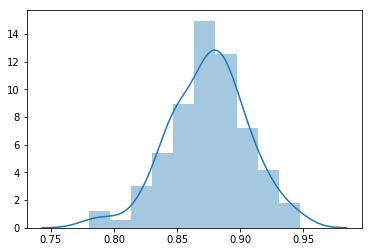

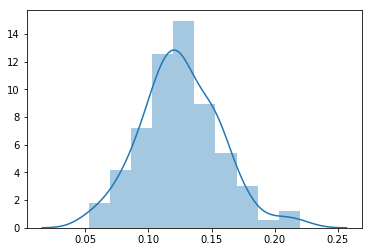

--------------------------------


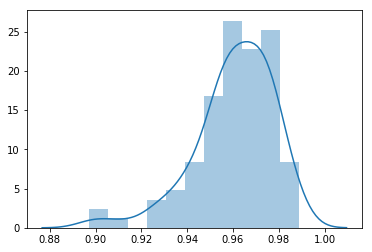

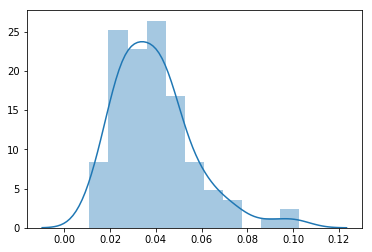

--------------------------------


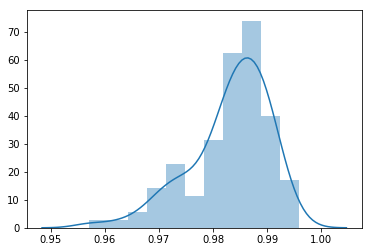

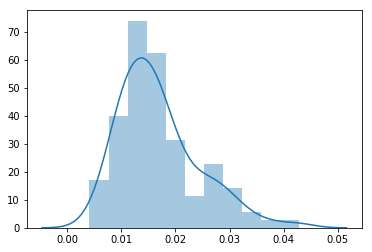

--------------------------------


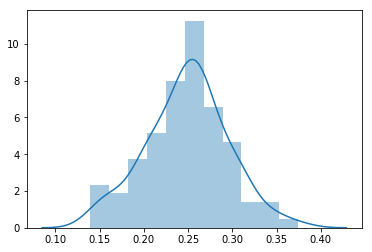

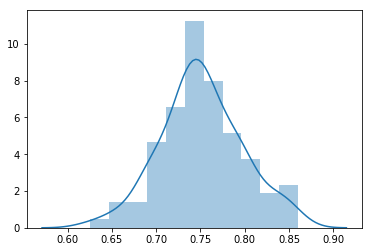

--------------------------------


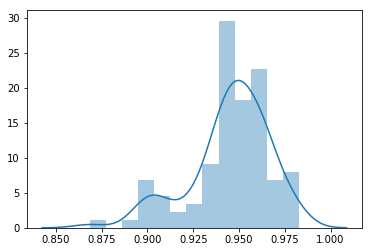

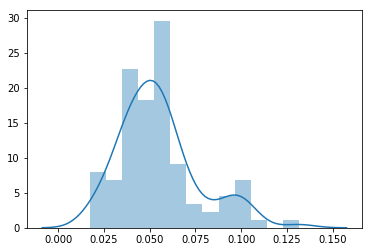

--------------------------------


In [69]:
for i in range(5):
    sns.distplot(softmax[:, i, 0])
    plt.show()
    
    sns.distplot(softmax[:, i, 1])
    plt.show()
    print('--------------------------------')

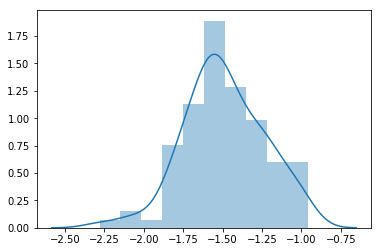

In [62]:
ax = sns.distplot(a[:, 4, 1])

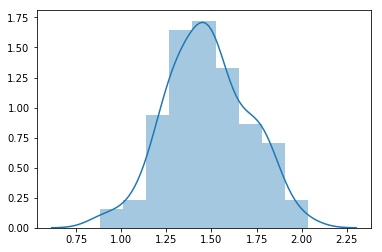

In [63]:
ax = sns.distplot(a[:, 4, 0])

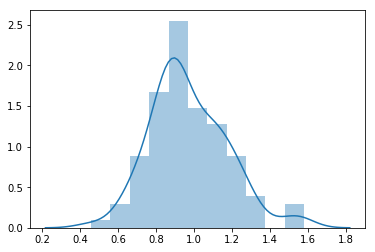

In [29]:
ax = sns.distplot(outputs.data.cpu().numpy()[:, 0])

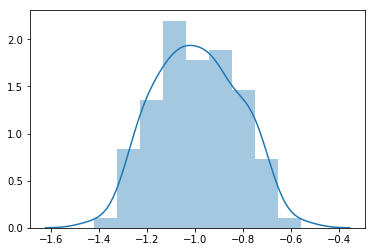

In [30]:
ax = sns.distplot(outputs.data.cpu().numpy()[:, 1])

In [21]:
x.shape

torch.Size([100, 3, 32, 32])

In [22]:
y.shape

torch.Size([100])

In [48]:
y

tensor([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 0], device='cuda:0')

# Study on Prediction Uncertainty

In [18]:
from sklearn.metrics import roc_auc_score

def get_roc_auc_score(y_all):
    return roc_auc_score(y_all['y_true'].values, y_all['y_pred'].values)

In [19]:
get_roc_auc_score(y_all)

0.965998812547679

In [20]:
from sklearn.metrics import confusion_matrix

def get_confusion_matrix(y_all):
    return confusion_matrix(y_all['y_true'].values, y_all['y_pred'].values, labels=[0, 1])

In [21]:
get_confusion_matrix(y_all)

array([[25632,   586],
       [  812, 16975]])

In [22]:
tn, fp, fn, tp = get_confusion_matrix(y_all).ravel()

In [23]:
get_confusion_matrix(y_all).ravel()

array([25632,   586,   812, 16975])

In [24]:
import seaborn as sns
def plot_confusion_matrix(y_all):
    cm = get_confusion_matrix(y_all)
    plt.figure()
    plt.title('Confusion Matrix')
    ax = sns.heatmap(cm)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Real')
    plt.show()
    return cm

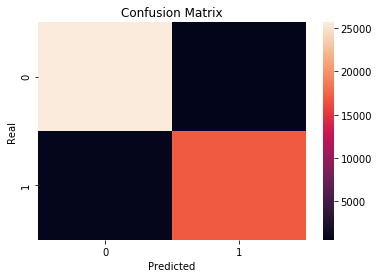

In [25]:
a = plot_confusion_matrix(y_all)

In [ ]:
# Roc under curve of each approach
def plot_
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_test, y_pred_rf_lm)

In [13]:
def plot_samples_batch(batch_samples):
    for i in range(batch_samples.shape[0]):
        plot_hist(img_samples=batch_samples[i,:,:])

In [14]:
def plot_hist(img_samples):
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.hist(samples_img[:, 0], bins=25)

    plt.subplot(122)
    plt.hist(samples_img[:, 1], bins=25)
    plt.show()

In [15]:
correct = 0
for data, target in val_loader:
    data, target = data.cuda(), target.cuda()
    with torch.no_grad():
        output, softmax, mixed_fs, samples = likelihood(model(data))
#         plot_samples_batch(batch_samples=samples)
        pred = output.probs.argmax(1)
        correct += pred.eq(target.view_as(pred)).cpu().sum()
        break
accuracy = 100. * correct / float(len(val_loader.dataset))
print(f'Validation set: Accuracy: {correct}/{len(val_loader.dataset)} ({accuracy}%)')


Validation set: Accuracy: 392/44005 (0%)


In [16]:
target = target.cpu()
softmax, mixed_fs, samples = softmax.cpu(), mixed_fs.cpu(), samples.cpu()

In [18]:
softmax.shape

torch.Size([400, 100, 2])

In [19]:
mixed_fs.shape

torch.Size([2, 40000])

In [33]:
mixed_fs_transf = mixed_fs.t().view(batch_size, 100, num_classes)
mixed_fs_transf.shape

torch.Size([400, 100, 2])

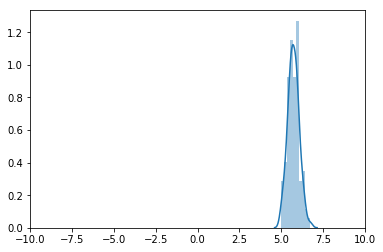

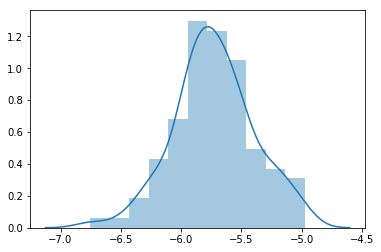

In [37]:
ax = sns.distplot(mixed_fs_transf[0,:,0])
ax.set_xlim([-10, 10])
plt.show()
sns.distplot(mixed_fs_transf[0,:,1])
plt.show()

In [39]:
np.exp(5)

148.4131591025766

In [40]:
np.abs(5.1/10)

0.5

In [20]:
samples.shape

torch.Size([512, 400, 100])

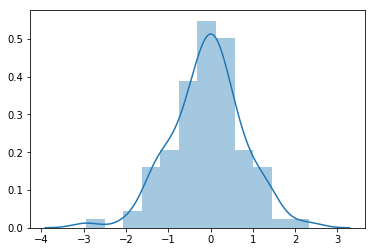

In [26]:
sns.distplot(samples[0,0,:])

In [41]:
mixed_fs_transf[0,0,0]

tensor(5.4505)

In [42]:
mixed_fs_transf[0,0,1]

tensor(-5.5529)

0.49530145227838673

In [16]:
output.probs.shape

torch.Size([800, 2])

In [17]:
samples = samples.cpu().numpy()

NameError: name 'samples' is not defined

In [17]:
import seaborn as sns

/home/alberto/.conda/envs/fastai/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


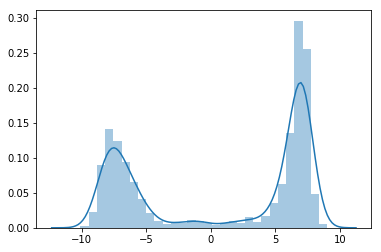

In [18]:
sns.distplot(mixed_fs[0,:].cpu())

In [19]:
samples_mixed_fs.t().shape

torch.Size([80000, 2])

In [20]:
samples_mixed_fs.t().view(batch_size, 100, num_classes).shape

torch.Size([800, 100, 2])

In [25]:
samples_mixed_fs_transformed = samples_mixed_fs.t().view(batch_size, 100, num_classes).cpu()
samples_mixed_fs_transformed.shape

torch.Size([800, 100, 2])

In [22]:
samples_softmax = samples_softmax.cpu()

In [45]:
samples_mixed_fs_transformed[i,:,0].shape

torch.Size([100])

#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
##############

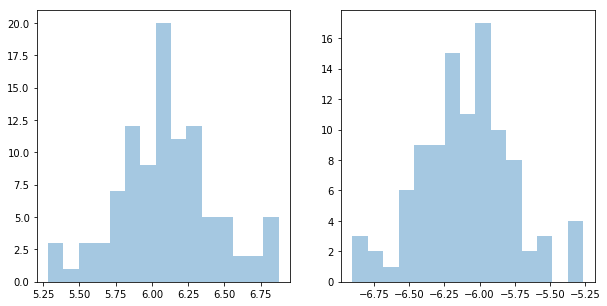

	Softmax
Prediction == 0. Mean = 1.0. Std = 0.0
Prediction == 1. Mean = 0.0. Std = 0.0


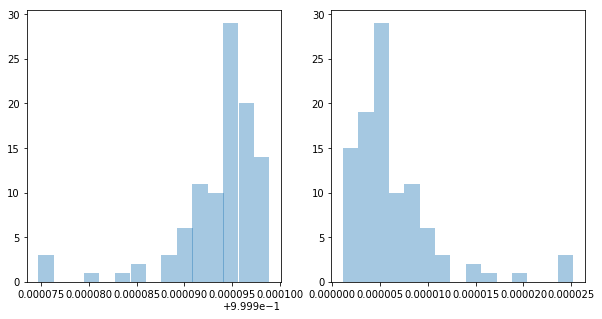

#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
##############

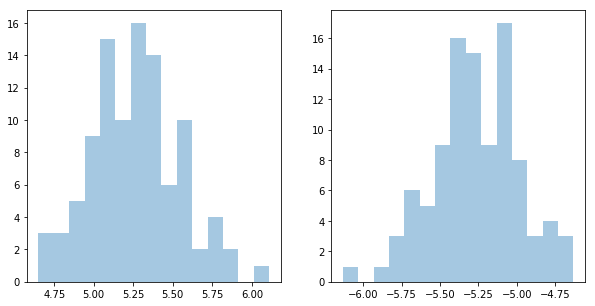

	Softmax
Prediction == 0. Mean = 1.0. Std = 0.0
Prediction == 1. Mean = 0.0. Std = 0.0


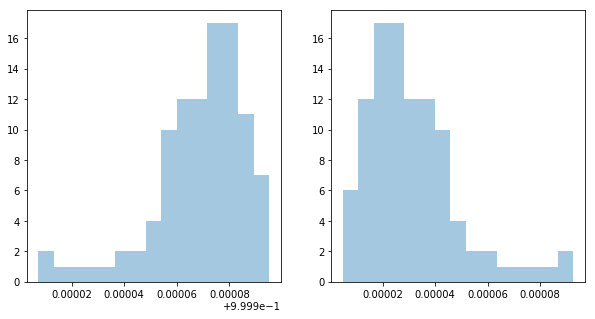

#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
##############

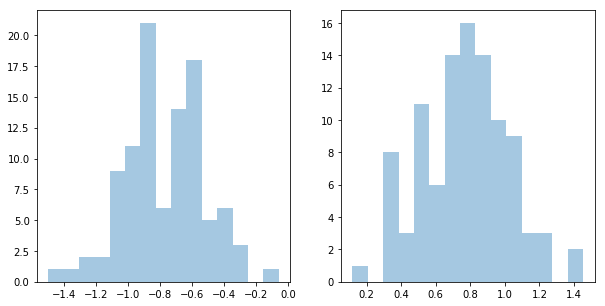

	Softmax
Prediction == 0. Mean = 0.188. Std = 0.074
Prediction == 1. Mean = 0.812. Std = 0.074


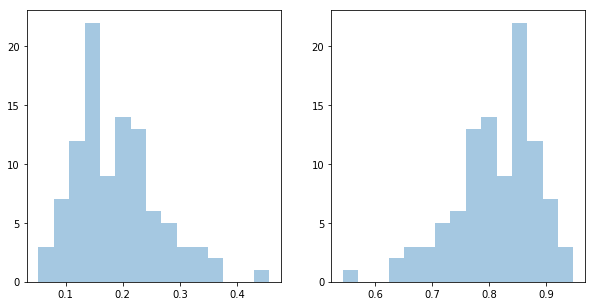

#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
##############

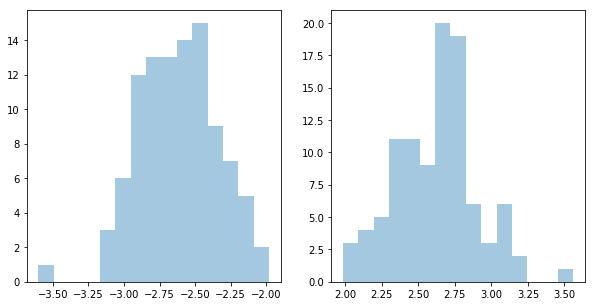

	Softmax
Prediction == 0. Mean = 0.006. Std = 0.004
Prediction == 1. Mean = 0.994. Std = 0.004


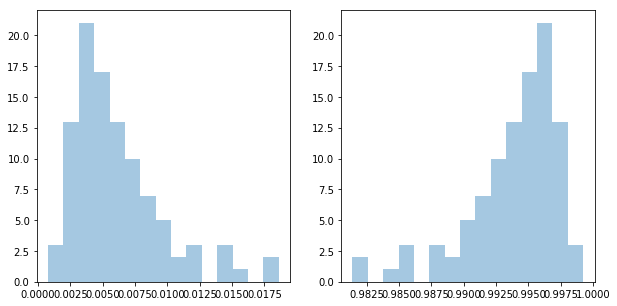

#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
Actual Target: 1
Class predicted: 0
Prediction == 0. Mean = 0.332. Std = 0.243
Prediction == 1. Mean = -0.323. Std = 0.245


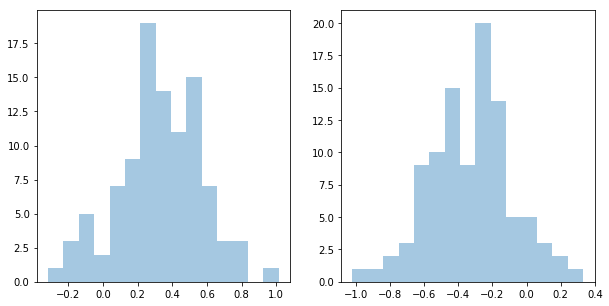

	Softmax
Prediction == 0. Mean = 0.651. Std = 0.105
Prediction == 1. Mean = 0.349. Std = 0.105


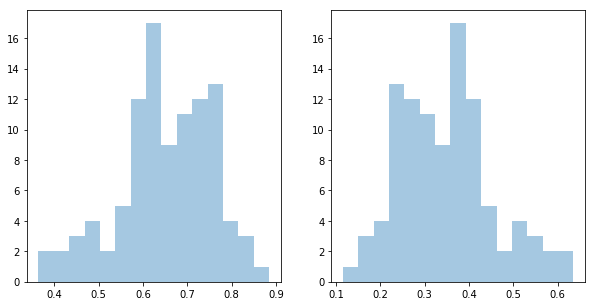

#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
##############

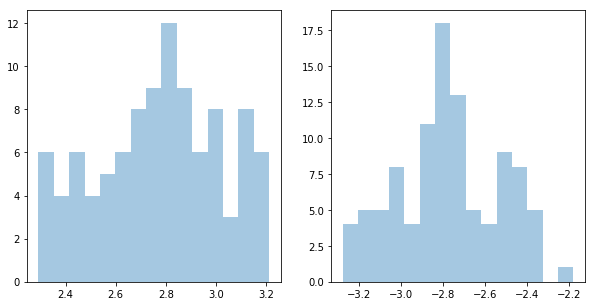

	Softmax
Prediction == 0. Mean = 0.996. Std = 0.002
Prediction == 1. Mean = 0.004. Std = 0.002


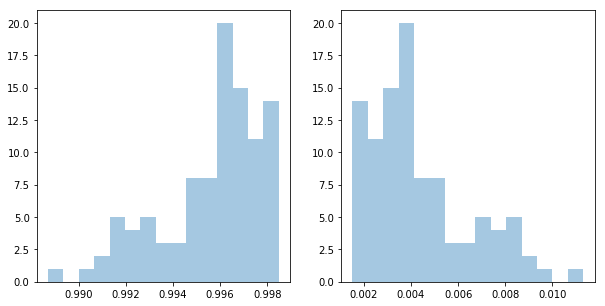

#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
##############

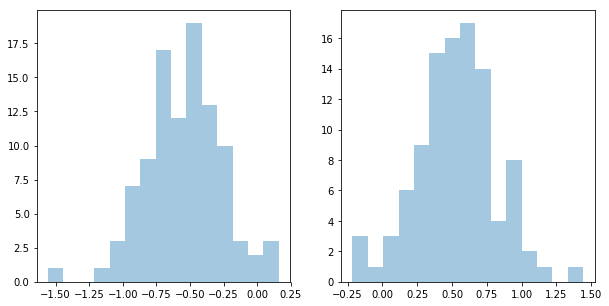

	Softmax
Prediction == 0. Mean = 0.267. Std = 0.106
Prediction == 1. Mean = 0.733. Std = 0.106


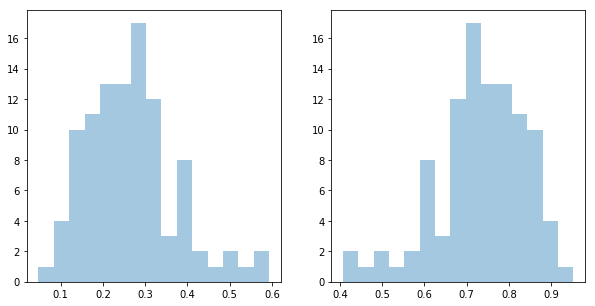

#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
#########################################################
Actual Target: 0
Class predicted: 1
Prediction == 0. Mean = -1.454. Std = 0.258
Prediction == 1. Mean = 1.46. Std = 0.256


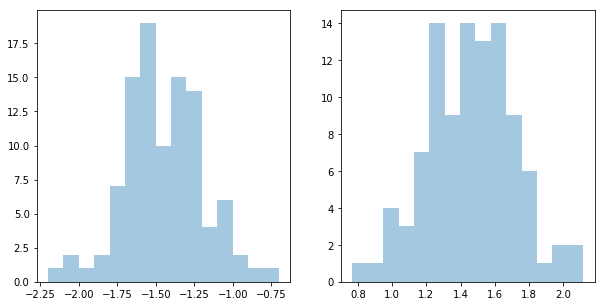

	Softmax
Prediction == 0. Mean = 0.057. Std = 0.029
Prediction == 1. Mean = 0.943. Std = 0.029


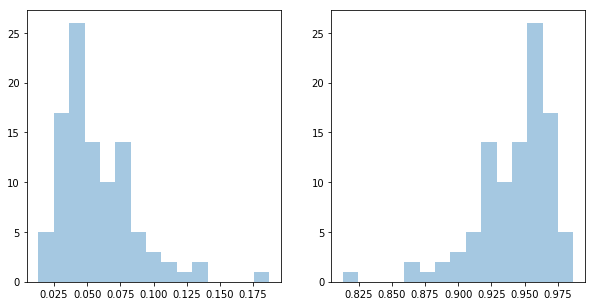

#########################################################
#########################################################
#########################################################
#########################################################


In [45]:
ranges = []
correct = pred.cpu().eq(target.view_as(pred.cpu()))
for i in range(batch_size):
# for i in range(10):
    print('#########################################################')
    target_i = target[i]
    pred_i = output.probs[i,:].cpu().argmax()
    
    ranges.append(float(softmax[i,:,1].max()-softmax[i,:,1].min()))
    
    if target_i != pred_i:
        print(f'Actual Target: {target_i}')
        print(f'Class predicted: {pred_i}')
        
        plt.figure(figsize=(10,5))
        plt.subplot(121)
        class_ = 0
        sns.distplot(mixed_fs_transf[i,:,class_], bins=15, kde=False)
        mean = float(torch.mean(mixed_fs_transf[i,:,class_]))
        std = float(torch.std(mixed_fs_transf[i,:,class_]))
        print(f'Prediction == {class_}. Mean = {round(mean, 3)}. Std = {round(std, 3)}')
    #     plt.hist(samples_img[:, 0], bins=25)

        plt.subplot(122)
        class_ = 1
        sns.distplot(mixed_fs_transf[i,:,class_], bins=15, kde=False)
        mean = float(torch.mean(mixed_fs_transf[i,:,class_]))
        std = float(torch.std(mixed_fs_transf[i,:,class_]))
        print(f'Prediction == {class_}. Mean = {round(mean, 3)}. Std = {round(std, 3)}')
        plt.show()

    #     plt.figure(figsize=(10,5))
    #     sns.distplot(samples_mixed_fs_transformed[i,:,:].reshape(-1), bins=50)
    #     plt.show()
        print('\tSoftmax')
        plt.figure(figsize=(10,5))
        plt.subplot(121)
        class_ = 0 
        ax = sns.distplot(softmax[i,:,class_], bins=15, kde=False)
        mean = float(torch.mean(softmax[i,:,class_]))
        std = float(torch.std(softmax[i,:,class_]))
        print(f'Prediction == {class_}. Mean = {round(mean, 3)}. Std = {round(std, 3)}')
    #     ax.set_xlim([-0.05,1.05])
    #     plt.hist(samples_img[:, 0], bins=25)

        plt.subplot(122)
        class_ = 1
        ax = sns.distplot(softmax[i,:,class_], bins=15, kde=False)
        mean = float(torch.mean(softmax[i,:,class_]))
        std = float(torch.std(softmax[i,:,class_]))
        print(f'Prediction == {class_}. Mean = {round(mean, 3)}. Std = {round(std, 3)}')
    #     ax.set_xlim([-0.05,1.05])
        plt.show()
    
#     plt.figure(figsize=(10,5))
#     sns.distplot(samples_softmax[i,:,:].reshape(-1), bins=500, kde=False)
#     plt.show()

    

In [53]:
(samples_softmax[i,:,0] + samples_softmax[i,:,1]).sum()

tensor(100.)

In [51]:
samples_softmax[i,:100,1]

tensor([2.8988e-06, 5.1841e-06, 6.0128e-06, 9.1687e-06, 5.9303e-06, 4.7068e-06,
        7.7977e-06, 8.3893e-06, 1.3645e-05, 2.5217e-06, 6.3066e-06, 3.2017e-06,
        8.7936e-06, 6.3153e-06, 4.6623e-06, 7.9178e-06, 4.9986e-06, 8.7357e-06,
        4.5916e-06, 7.3439e-06, 3.9528e-06, 7.6004e-06, 2.8939e-06, 3.4992e-06,
        1.2340e-05, 5.2994e-06, 1.2344e-06, 1.2128e-05, 4.8975e-06, 3.8792e-06,
        4.8763e-06, 1.0875e-05, 2.3632e-06, 4.5864e-06, 2.7801e-05, 9.6654e-06,
        4.1531e-06, 1.2566e-05, 1.0318e-05, 5.1657e-06, 2.8386e-06, 8.0653e-06,
        3.7147e-06, 5.8869e-06, 6.1139e-06, 3.3752e-06, 4.8867e-06, 2.7519e-06,
        3.8235e-06, 4.5224e-06, 4.9360e-06, 7.7635e-06, 9.8143e-06, 5.0593e-06,
        7.6984e-06, 5.7662e-06, 2.4981e-05, 9.6285e-06, 3.5060e-06, 2.2815e-06,
        4.1134e-06, 9.6790e-06, 6.5883e-06, 1.4588e-05, 1.2601e-05, 1.0429e-05,
        3.2107e-06, 7.3035e-06, 1.5720e-06, 4.8975e-06, 1.2479e-05, 3.4263e-06,
        2.2844e-06, 1.2639e-05, 8.4776e-

In [37]:
correct = correct.numpy()

In [39]:
import pandas as pd
df_ranges = pd.DataFrame({'correct': list(correct),
                         'ranges': ranges})
df_ranges.head()

,correct,ranges
0,1,0.000070
1,1,0.000024
2,1,0.000003
3,1,0.000008
4,1,0.000100


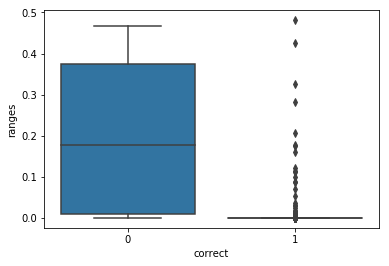

In [57]:
sns.boxplot(x='correct', y='ranges', data=df_ranges, whis=1)

NameError: name 'samples_img' is not defined

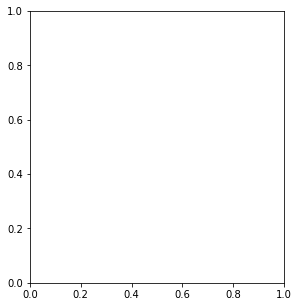

In [21]:
plot_hist(img_samples=samples_mixed_fs.transpose)